In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from PIL import Image
import os

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')


Using device: cuda
GPU: Tesla T4


In [ ]:
base_path = '/content/drive/MyDrive/Mammo'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# For original rescaling (equivalent to rescale=1./255 in Keras)
transform_simple = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # This automatically converts [0,255] to [0,1]
])

# Load datasets
train_dataset = ImageFolder(f'{base_path}/train/', transform=transform_simple)
val_dataset = ImageFolder(f'{base_path}/val/', transform=transform_simple)
test_dataset = ImageFolder(f'{base_path}/test/', transform=transform_simple)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")
print(f"Class to index: {train_dataset.class_to_idx}")


Training samples: 3816
Validation samples: 1908
Test samples: 1908
Classes: ['Benign', 'Malignant']
Class to index: {'Benign': 0, 'Malignant': 1}


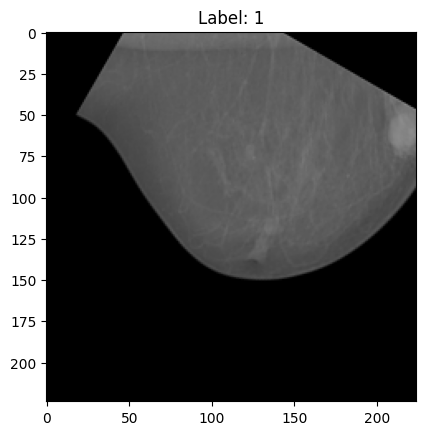

Image shape: torch.Size([64, 3, 224, 224])


In [ ]:
def show_sample_images():
    dataiter = iter(train_loader)
    images, labels = next(dataiter)

    # Show first image
    img = images[0]
    plt.imshow(img.permute(1, 2, 0))  # Change from CHW to HWC for matplotlib
    plt.title(f"Label: {labels[0].item()}")
    plt.show()

    print(f"Image shape: {images.shape}")

show_sample_images()

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=1):
        super(CustomCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the flattened size
        # After 3 pooling layers: 224 -> 112 -> 56 -> 28
        # So: 28 * 28 * 64 = 50176
        self.fc1 = nn.Linear(28 * 28 * 64, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification

        return x


In [ ]:
model = CustomCNN(num_classes=1).to(device)
print(model)

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=64, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)  # Convert to float and add dimension

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.float().unsqueeze(1).to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return train_losses, train_accuracies, val_losses, val_accuracies


In [ ]:
print("Training Custom CNN...")
history = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=25)

# Save the model
torch.save(model.state_dict(), f'{base_path}/custom_model_pytorch.pth')


Training Custom CNN...
Epoch [1/25], Train Loss: 5.5393, Train Acc: 0.6509, Val Loss: 0.6387, Val Acc: 0.6698
Epoch [2/25], Train Loss: 0.6469, Train Acc: 0.6698, Val Loss: 0.6355, Val Acc: 0.6698
Epoch [3/25], Train Loss: 0.6478, Train Acc: 0.6688, Val Loss: 0.6341, Val Acc: 0.6698
Epoch [4/25], Train Loss: 0.6417, Train Acc: 0.6698, Val Loss: 0.6315, Val Acc: 0.6698
Epoch [5/25], Train Loss: 0.6383, Train Acc: 0.6701, Val Loss: 0.6297, Val Acc: 0.6771
Epoch [6/25], Train Loss: 0.6289, Train Acc: 0.6751, Val Loss: 0.6196, Val Acc: 0.6787
Epoch [7/25], Train Loss: 0.6247, Train Acc: 0.6819, Val Loss: 0.6254, Val Acc: 0.6798
Epoch [8/25], Train Loss: 0.6150, Train Acc: 0.6900, Val Loss: 0.6070, Val Acc: 0.6913
Epoch [9/25], Train Loss: 0.5995, Train Acc: 0.6992, Val Loss: 0.5994, Val Acc: 0.6834
Epoch [10/25], Train Loss: 0.5856, Train Acc: 0.6994, Val Loss: 0.5928, Val Acc: 0.6923
Epoch [11/25], Train Loss: 0.5786, Train Acc: 0.7068, Val Loss: 0.5900, Val Acc: 0.7007
Epoch [12/25], Tra

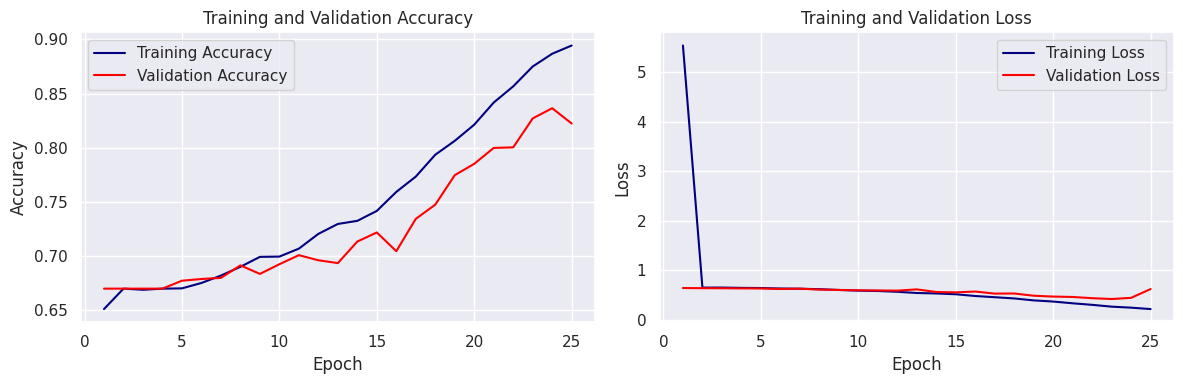

In [ ]:
def plot_training_history(train_losses, train_accs, val_losses, val_accs):
    sns.set(rc={'figure.figsize':(11.7,8.27)})

    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_accs)+1), train_accs, color='navy', label='Training Accuracy')
    plt.plot(range(1, len(val_accs)+1), val_accs, color='red', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_losses)+1), train_losses, color='navy', label='Training Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, color='red', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history[0], history[1], history[2], history[3])


Test Accuracy: 0.8223


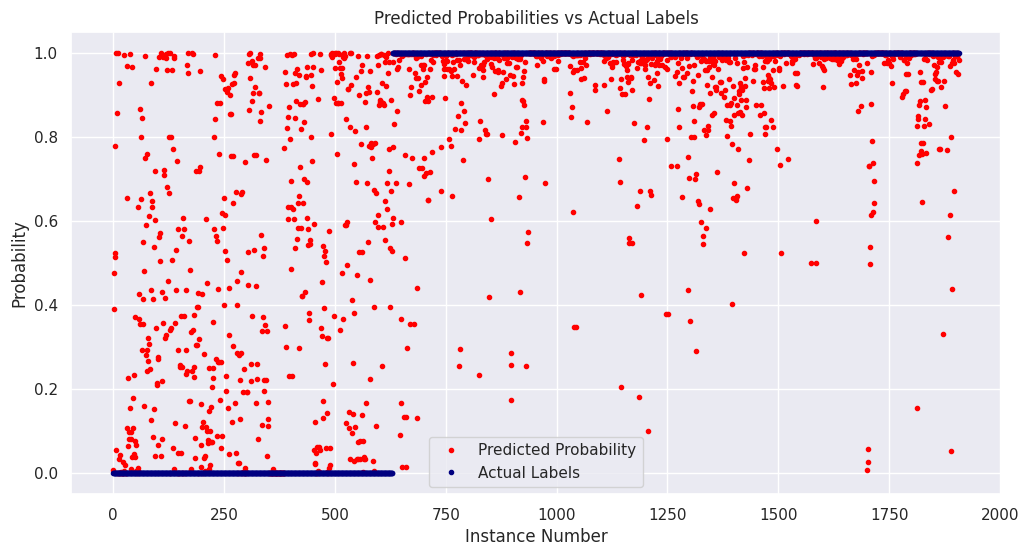

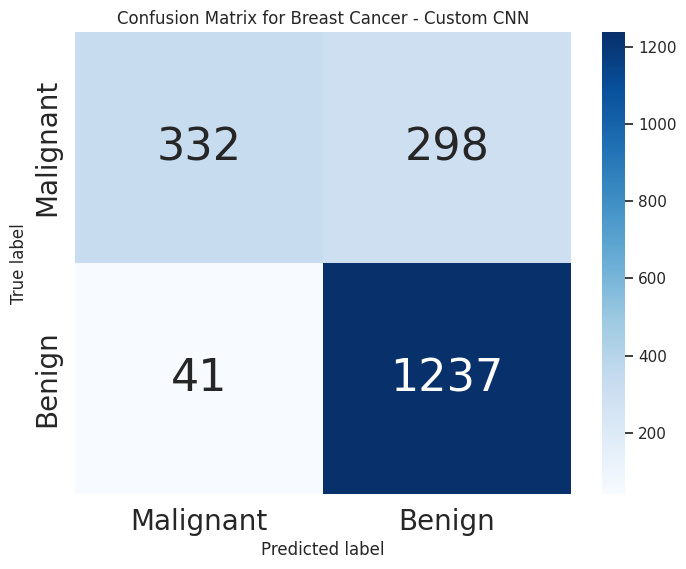

Classification Report - Custom CNN:
                     precision    recall  f1-score   support

   Benign (Class 0)       0.89      0.53      0.66       630
Malignant (Class 1)       0.81      0.97      0.88      1278

           accuracy                           0.82      1908
          macro avg       0.85      0.75      0.77      1908
       weighted avg       0.83      0.82      0.81      1908



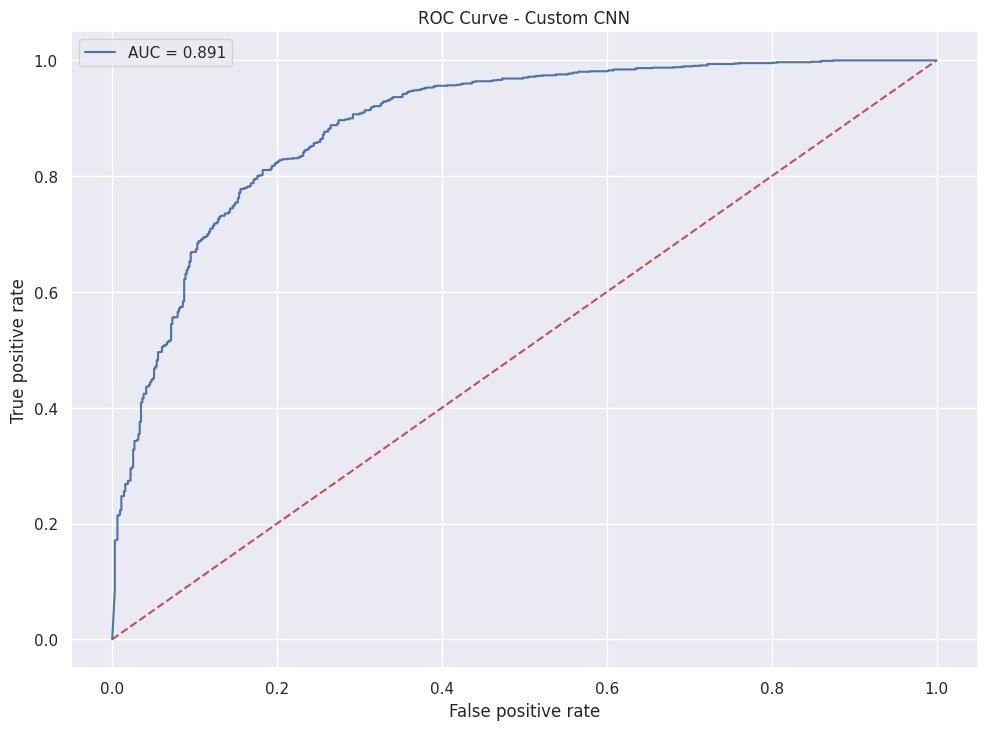

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probabilities = outputs.cpu().numpy()
            predictions = (outputs > 0.5).float().cpu().numpy()

            all_probabilities.extend(probabilities.flatten())
            all_predictions.extend(predictions.flatten())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_predictions), np.array(all_probabilities)

# Evaluate the custom model
y_test, y_pred, y_pred_prob = evaluate_model(model, test_loader)

# Calculate accuracy
accuracy = (y_pred == y_test).mean()
print(f'Test Accuracy: {accuracy:.4f}')

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_pred_prob, '.', color='red', label='Predicted Probability')
plt.plot(y_test, '.', color='navy', label='Actual Labels')
plt.xlabel('Instance Number')
plt.ylabel('Probability')
plt.legend()
plt.title('Predicted Probabilities vs Actual Labels')
plt.show()

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, annot=True,
            annot_kws={"size": 32}, fmt='g')
plt.xticks([0.5, 1.5], ['Malignant', 'Benign'], fontsize=20)
plt.yticks([0.5, 1.5], ['Malignant', 'Benign'], fontsize=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for Breast Cancer - Custom CNN')
plt.show()

# Classification Report
print("Classification Report - Custom CNN:")
print(classification_report(y_test, y_pred, target_names=['Benign (Class 0)', 'Malignant (Class 1)']))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
area_under_curve = auc(fpr, tpr)

plt.figure()
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label=f'AUC = {area_under_curve:.3f}')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve - Custom CNN')
plt.legend(loc='best')
plt.show()


**II-Transfer Learning:**

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:11<00:00, 47.4MB/s]


VGG16 Transfer Learning Model:
VGG16Transfer(
  (backbone): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

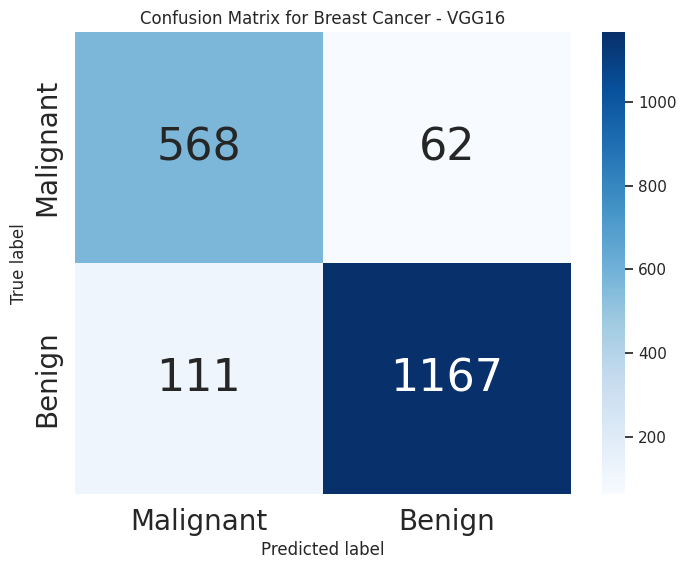

Classification Report - VGG16:
                     precision    recall  f1-score   support

   Benign (Class 0)       0.84      0.90      0.87       630
Malignant (Class 1)       0.95      0.91      0.93      1278

           accuracy                           0.91      1908
          macro avg       0.89      0.91      0.90      1908
       weighted avg       0.91      0.91      0.91      1908



In [ ]:
class VGG16Transfer(nn.Module):
    def __init__(self, num_classes=1, freeze_features=True):
        super(VGG16Transfer, self).__init__()

        # Load pretrained VGG16
        self.backbone = models.vgg16(pretrained=True)

        # Freeze feature extraction layers if specified
        if freeze_features:
            for param in self.backbone.features.parameters():
                param.requires_grad = False

        # Replace classifier
        self.backbone.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 512),
            nn.ReLU(True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.backbone(x)

# Initialize VGG16 model
vgg_model = VGG16Transfer(num_classes=1, freeze_features=True).to(device)
print("VGG16 Transfer Learning Model:")
print(vgg_model)

# New optimizer for VGG16
vgg_optimizer = optim.Adam(vgg_model.parameters(), lr=0.00005)

# Train VGG16 model
print("\nTraining VGG16 Transfer Learning Model...")
vgg_history = train_model(vgg_model, train_loader, test_loader, criterion, vgg_optimizer, num_epochs=10)

# Save VGG16 model
torch.save(vgg_model.state_dict(), f'{base_path}/vgg16_model_pytorch.pth')

# Evaluate VGG16 model
y_test_vgg, y_pred_vgg, y_pred_prob_vgg = evaluate_model(vgg_model, test_loader)
vgg_accuracy = (y_pred_vgg == y_test_vgg).mean()
print(f'VGG16 Test Accuracy: {vgg_accuracy:.4f}')

# VGG16 Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_vgg, y_pred_vgg), cmap=plt.cm.Blues, annot=True,
            annot_kws={"size": 32}, fmt='g')
plt.xticks([0.5, 1.5], ['Malignant', 'Benign'], fontsize=20)
plt.yticks([0.5, 1.5], ['Malignant', 'Benign'], fontsize=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for Breast Cancer - VGG16')
plt.show()

print("Classification Report - VGG16:")
print(classification_report(y_test_vgg, y_pred_vgg, target_names=['Benign (Class 0)', 'Malignant (Class 1)']))


**Fine Tune VGG16:**

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Training VGG16 Fine-tuning Model...
Epoch [1/10], Train Loss: 0.6597, Train Acc: 0.6074, Val Loss: 0.5441, Val Acc: 0.7537
Epoch [2/10], Train Loss: 0.4779, Train Acc: 0.7817, Val Loss: 0.4097, Val Acc: 0.8407
Epoch [3/10], Train Loss: 0.3630, Train Acc: 0.8643, Val Loss: 0.3548, Val Acc: 0.8747
Epoch [4/10], Train Loss: 0.2781, Train Acc: 0.9154, Val Loss: 0.2780, Val Acc: 0.9156
Epoch [5/10], Train Loss: 0.2152, Train Acc: 0.9458, Val Loss: 0.2626, Val Acc: 0.9198
Epoch [6/10], Train Loss: 0.1569, Train Acc: 0.9706, Val Loss: 0.1920, Val Acc: 0.9492
Epoch [7/10], Train Loss: 0.1208, Train Acc: 0.9819, Val Loss: 0.1976, Val Acc: 0.9361
Epoch [8/10], Train Loss: 0.0852, Train Acc: 0.9921, Val Loss: 0.1287, Val Acc: 0.9659
Epoch [9/10], Train Loss: 0.0611, Train Acc: 0.9974, Val Loss: 0.1287, Val Acc: 0.9607
Epoch [10/10], Train Loss: 0.0451, Train Acc: 0.9995, Val Loss: 0.1095, Val Acc: 0.9686
VGG16 Fine-tuning Test Accuracy: 0.9686


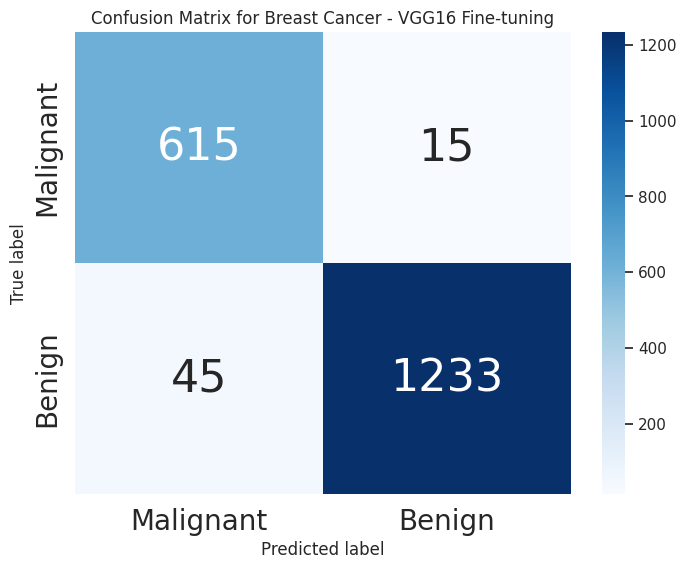

Classification Report - VGG16 Fine-tuning:
                     precision    recall  f1-score   support

   Benign (Class 0)       0.93      0.98      0.95       630
Malignant (Class 1)       0.99      0.96      0.98      1278

           accuracy                           0.97      1908
          macro avg       0.96      0.97      0.96      1908
       weighted avg       0.97      0.97      0.97      1908



In [ ]:
class VGG16FineTune(nn.Module):
    def __init__(self, num_classes=1):
        super(VGG16FineTune, self).__init__()

        # Load pretrained VGG16
        self.backbone = models.vgg16(pretrained=True)

        # Unfreeze last few layers (equivalent to unfreezing block4 and block5)
        # In VGG16, we'll unfreeze the last few convolutional layers
        for i, param in enumerate(self.backbone.features.parameters()):
            if i >= 20:  # Unfreeze last layers
                param.requires_grad = True
            else:
                param.requires_grad = False

        # Replace classifier with GlobalAveragePooling equivalent
        self.backbone.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.backbone.classifier = nn.Sequential(
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.backbone.features(x)
        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.backbone.classifier(x)
        return x

# Initialize fine-tuning model
vgg_finetune = VGG16FineTune(num_classes=1).to(device)
vgg_finetune_optimizer = optim.Adam(vgg_finetune.parameters(), lr=0.00005)

print("\nTraining VGG16 Fine-tuning Model...")
vgg_finetune_history = train_model(vgg_finetune, train_loader, test_loader, criterion, vgg_finetune_optimizer, num_epochs=10)

# Save fine-tuned model
torch.save(vgg_finetune.state_dict(), f'{base_path}/vgg16_finetune_pytorch.pth')

# Evaluate fine-tuned model
y_test_ft, y_pred_ft, y_pred_prob_ft = evaluate_model(vgg_finetune, test_loader)
ft_accuracy = (y_pred_ft == y_test_ft).mean()
print(f'VGG16 Fine-tuning Test Accuracy: {ft_accuracy:.4f}')

# Fine-tuning Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_ft, y_pred_ft), cmap=plt.cm.Blues, annot=True,
            annot_kws={"size": 32}, fmt='g')
plt.xticks([0.5, 1.5], ['Malignant', 'Benign'], fontsize=20)
plt.yticks([0.5, 1.5], ['Malignant', 'Benign'], fontsize=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for Breast Cancer - VGG16 Fine-tuning')
plt.show()

print("Classification Report - VGG16 Fine-tuning:")
print(classification_report(y_test_ft, y_pred_ft, target_names=['Benign (Class 0)', 'Malignant (Class 1)']))


**III-Transfer Learning:ResNet50**

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:02<00:00, 40.3MB/s]



Training ResNet50 Transfer Learning Model...
Epoch [1/10], Train Loss: 0.6527, Train Acc: 0.6454, Val Loss: 0.6286, Val Acc: 0.6698
Epoch [2/10], Train Loss: 0.6450, Train Acc: 0.6648, Val Loss: 0.6271, Val Acc: 0.6698
Epoch [3/10], Train Loss: 0.6399, Train Acc: 0.6664, Val Loss: 0.6230, Val Acc: 0.6698
Epoch [4/10], Train Loss: 0.6304, Train Acc: 0.6701, Val Loss: 0.6182, Val Acc: 0.6698
Epoch [5/10], Train Loss: 0.6287, Train Acc: 0.6669, Val Loss: 0.6143, Val Acc: 0.6698
Epoch [6/10], Train Loss: 0.6231, Train Acc: 0.6688, Val Loss: 0.6093, Val Acc: 0.6698
Epoch [7/10], Train Loss: 0.6193, Train Acc: 0.6716, Val Loss: 0.6052, Val Acc: 0.6698
Epoch [8/10], Train Loss: 0.6104, Train Acc: 0.6730, Val Loss: 0.6015, Val Acc: 0.6698
Epoch [9/10], Train Loss: 0.6074, Train Acc: 0.6761, Val Loss: 0.5980, Val Acc: 0.6714
Epoch [10/10], Train Loss: 0.6074, Train Acc: 0.6785, Val Loss: 0.5944, Val Acc: 0.6740
ResNet50 Test Accuracy: 0.6740


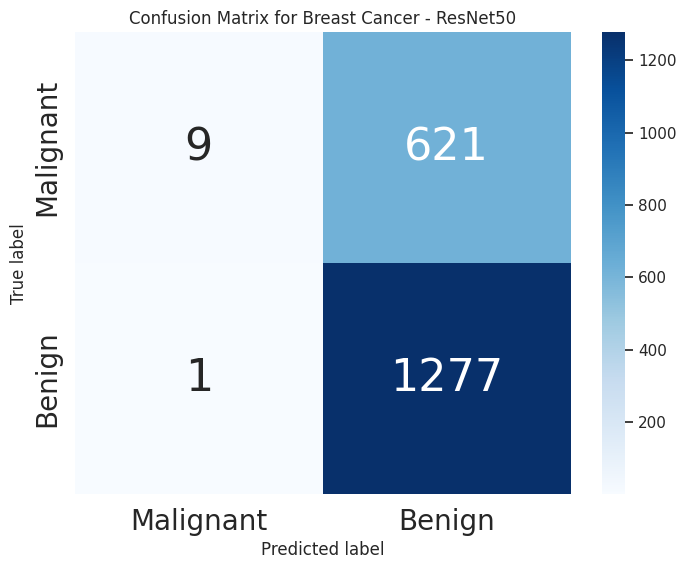

Classification Report - ResNet50:
                     precision    recall  f1-score   support

   Benign (Class 0)       0.90      0.01      0.03       630
Malignant (Class 1)       0.67      1.00      0.80      1278

           accuracy                           0.67      1908
          macro avg       0.79      0.51      0.42      1908
       weighted avg       0.75      0.67      0.55      1908



In [ ]:
class ResNet50Transfer(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNet50Transfer, self).__init__()

        # Load pretrained ResNet50
        self.backbone = models.resnet50(pretrained=True)

        # Freeze all layers
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Replace final fully connected layer
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.backbone(x)

# Initialize ResNet50 model
resnet_model = ResNet50Transfer(num_classes=1).to(device)
resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=0.00005)

print("\nTraining ResNet50 Transfer Learning Model...")
resnet_history = train_model(resnet_model, train_loader, test_loader, criterion, resnet_optimizer, num_epochs=10)

# Save ResNet50 model
torch.save(resnet_model.state_dict(), f'{base_path}/resnet50_model_pytorch.pth')

# Evaluate ResNet50 model
y_test_resnet, y_pred_resnet, y_pred_prob_resnet = evaluate_model(resnet_model, test_loader)
resnet_accuracy = (y_pred_resnet == y_test_resnet).mean()
print(f'ResNet50 Test Accuracy: {resnet_accuracy:.4f}')

# ResNet50 Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_resnet, y_pred_resnet), cmap=plt.cm.Blues, annot=True,
            annot_kws={"size": 32}, fmt='g')
plt.xticks([0.5, 1.5], ['Malignant', 'Benign'], fontsize=20)
plt.yticks([0.5, 1.5], ['Malignant', 'Benign'], fontsize=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for Breast Cancer - ResNet50')
plt.show()

print("Classification Report - ResNet50:")
print(classification_report(y_test_resnet, y_pred_resnet, target_names=['Benign (Class 0)', 'Malignant (Class 1)']))



In [ ]:
def visualize_predictions(model, test_loader, num_samples=25):
    model.eval()
    cancer_labels = ['Benign', 'Malignant']

    # Get a batch of test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Select random samples
    indices = np.random.choice(len(images), num_samples, replace=False)
    sample_images = images[indices]
    sample_labels = labels[indices]

    # Get predictions
    with torch.no_grad():
        sample_images = sample_images.to(device)
        outputs = model(sample_images)
        predictions = (outputs > 0.5).float().cpu().numpy().flatten()
        probabilities = outputs.cpu().numpy().flatten()

    # Plot
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        # Convert tensor to numpy and transpose for matplotlib
        img = sample_images[i].cpu().permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)  # Ensure values are in [0,1] range
        plt.imshow(img)

        pred_label = int(predictions[i])
        true_label = sample_labels[i].item()

        plt.xlabel(f'{cancer_labels[pred_label]} ({probabilities[i]:.3f})')
        plt.ylabel(f'{cancer_labels[true_label]}')

    plt.tight_layout()
    plt.show()

# Visualize predictions for custom CNN
print("Sample Predictions - Custom CNN:")
visualize_predictions(model, test_loader)


In [ ]:
def save_test_data(test_loader, save_path_X, save_path_y):
    """Save test data for consistent evaluation across models"""
    X_test_list = []
    y_test_list = []

    for images, labels in test_loader:
        X_test_list.append(images.numpy())
        y_test_list.append(labels.numpy())

    X_test = np.vstack(X_test_list)
    y_test = np.concatenate(y_test_list)

    with open(save_path_X, 'wb') as f:
        pickle.dump(X_test, f)
    with open(save_path_y, 'wb') as f:
        pickle.dump(y_test, f)

    print(f"Test data saved: X_test shape {X_test.shape}, y_test shape {y_test.shape}")

def load_test_data(load_path_X, load_path_y):
    """Load saved test data"""
    with open(load_path_X, 'rb') as f:
        X_test = pickle.load(f)
    with open(load_path_y, 'rb') as f:
        y_test = pickle.load(f)

    return X_test, y_test

# Save test data
save_test_data(test_loader, f'{base_path}/X_test_pytorch.pkl',  f'{base_path}/y_test_pytorch.pkl')


Test data saved: X_test shape (1908, 3, 224, 224), y_test shape (1908,)


In [ ]:
print("\n" + "="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)

models_results = {
    'Custom CNN': accuracy,
    'VGG16 Transfer': vgg_accuracy,
    'VGG16 Fine-tune': ft_accuracy,
    'ResNet50': resnet_accuracy
}

for model_name, acc in models_results.items():
    print(f"{model_name}: {acc:.4f}")

print("="*50)

# Save all results to a summary file
results_df = pd.DataFrame({
    'Model': list(models_results.keys()),
    'Accuracy': list(models_results.values())
})

results_df.to_csv(f'{base_path}/pytorch_results_summary.csv', index=False)
print("Results summary saved to pytorch_results_summary.csv")



MODEL COMPARISON SUMMARY
Custom CNN: 0.8223
VGG16 Transfer: 0.9093
VGG16 Fine-tune: 0.9686
ResNet50: 0.6740
Results summary saved to pytorch_results_summary.csv


In [ ]:
def predict_image(image_path):
    base_path1  = '/content/drive/MyDrive/Models_internship'
    # Define device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ])

    # Load model (make sure to set map_location)
    model = torch.load(f'{base_path1}/vgg16_finetune_pytorch.pth', map_location=device)
    model = model.to(device)
    model.eval()

    # Process image
    image = Image.open(image_path).convert('RGB')  # Convert to RGB to handle grayscale images
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    # Make prediction
    with torch.no_grad():
        output = model(image)
        probabilities = torch.sigmoid(output).cpu().numpy()  # Apply sigmoid for probabilities
        predictions = (probabilities > 0.5).astype(float)  # Convert to binary predictions

    # Return the actual results instead of undefined variables
    return predictions, probabilities

In [ ]:
prediction=predict_image('/content/drive/MyDrive/Models_internship/téléchargement (1).png')

TypeError: 'collections.OrderedDict' object is not callable